In [1]:
import os
import os.path as osp

import numpy as np
import math
import random

import open3d as o3d

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

import utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Prepare the ModelNet40 dataset

In [116]:
from scipy.stats import binned_statistic_2d

class ModelNet40(Dataset):
    def __init__(self,
        root: str, split: str,
        image_shape: tuple = (32, 32),
        proj_axes: list = [[0, 0, 1]]
    ):
        super().__init__()
        assert isinstance(image_shape, tuple) and len(image_shape) == 2, \
            "wrong image shape"

        assert osp.exists(root), \
            "invalid root for modelnet40 dataset"

        shape_names_file = osp.join(root, "modelnet40_shape_names.txt")
        assert osp.exists(shape_names_file), \
            "couldn't find shape-names txt file"
        with open(shape_names_file, 'r') as f:
            shape_names = sorted([line.strip() for line in f.readlines()])
            self.class_names = shape_names
            self.cls2idx = {v:i for i, v in enumerate(shape_names)}
            self.idx2cls = {i:v for i, v in enumerate(shape_names)}

        split_file = osp.join(root, f"modelnet40_{split}.txt")
        assert osp.exists(split_file), \
            "split file not exists"
        
        sample_names = []
        with open(split_file, 'r') as f:
            sample_names = sorted([line.strip() for line in f.readlines()])


        self.data = []
        for obj_name in sample_names:
            cls_name = obj_name.rsplit("_", 1)[0]
            self.data.append((osp.join(root, cls_name, f"{obj_name}.txt"), self.cls2idx[cls_name]))
        
        self.proj_axes = proj_axes
        self.image_shape = image_shape
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        file, gdth = self.data[index]
        points = np.loadtxt(file, delimiter=',')
        fmap = self.project_list(points, self.image_shape)
        return fmap, gdth
    
    def add_proj_dir(self, axis: np.ndarray):
        if not isinstance(axis, np.ndarray):
            axis = np.array(axis)
        assert len(axis.shape) == 1 and len(dir) == 3, "wrong projection axis shape"
        self.proj_axes.append(axis)

    def project_list(self, points: np.ndarray, image_shape: tuple):
        image_list = []
        for axis in self.proj_axes:
            image_list.append(self.project(points, axis, image_shape))
        return np.array(image_list)


    def project(self, points: np.ndarray, axis: np.ndarray, image_shape: tuple):
        assert len(points.shape) == 2 and points.shape[1] >= 3, "wrong 3d coordinate shape"
        coords = np.copy(points[:, :3])
        # move to center and scaled to [-1, +1]
        coords = coords - coords.mean(axis=0)
        coords = coords / np.max(np.sqrt(np.sum(coords**2, axis=1)))

        R = utils.A2B_R(axis, [0, 0, 1])
        coords = (R @ coords.T).T

        x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
        # from [-1, +1] to [0, H/W - 1]
        x = ((x + 1.0) / 2.0 * (image_shape[0] - 1)).astype(np.int32)
        y = ((y + 1.0) / 2.0 * (image_shape[1] - 1)).astype(np.int32)

        image = np.full((*image_shape, 3 + 1), 0.0, dtype=np.float32) # (x, y, z, r)
        z_buf = np.full(image_shape, -np.inf)

        for r, c, d, point in zip(x, y, z, points):
            if d > z_buf[r][c]:
                z_buf[r][c] = d
                image[r][c] = np.array([*point[:3], d])
        
        return np.transpose(image) # move channel axis to the first

(4, 4, 64, 64)


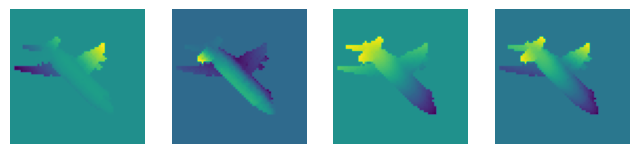

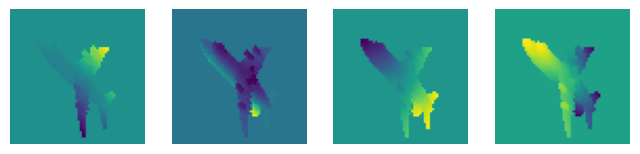

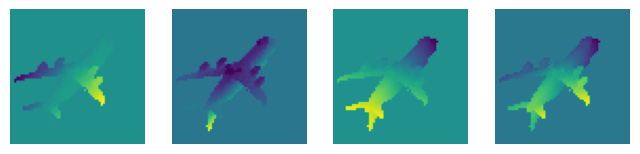

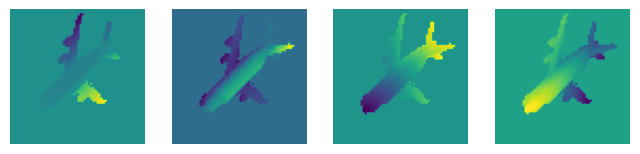

In [117]:
image_shape = (64, 64)
patch_shape = (4, 4)
# proj_axes = [
#     [int((int(x) - 0.5) * 2) for x in list(bin(i)[2:].zfill(3))] for i in range(2**3)
# ]
# proj_axes = [
#     [1, 0, 0],
#     [-1, 0, 0],
#     [0, 1, 0],
#     [0, -1, 0],
#     [0, 0, 1],
#     [0, 0, -1]
# ]
proj_axes = [
    [+1, +1, +1],
    [-1, -1, -1],
    [+1, -1, +1],
    [-1, +1, -1]
]

train_dataset = ModelNet40("./data/modelnet40", split="train", image_shape=image_shape, proj_axes=proj_axes)
# 定义训练集和验证集的大小
train_size = int(0.8 * len(train_dataset))  # 80% 用于训练
valid_size = len(train_dataset) - train_size  # 20% 用于验证
# 使用 random_split 进行划分
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])
testt_dataset = ModelNet40("./data/modelnet40", split="test", image_shape=image_shape, proj_axes=proj_axes)

for iter, (fmap, gdth) in enumerate(train_dataset):
    print(fmap.shape)
    for view in fmap:
        fig, axes = plt.subplots(1, 4, figsize=(8, 2))
        for ax, chnl in zip(axes.flatten(), view):
            ax.axis("off")
            ax.imshow(chnl)
        plt.show()
    break

In [5]:
import torch
import torch.nn as nn

class PatchSpliter(nn.Module):
    def __init__(self,
        image_shape: tuple,
        patch_shape: tuple,
        in_channels: int,
        hd_channels: int
    ):
        super().__init__()
        assert isinstance(image_shape, tuple) and len(image_shape) == 2, \
        "wrong image shape"
        assert isinstance(patch_shape, tuple) and len(patch_shape) == 2, \
        "wrong patch shape"

        self.spliter = nn.Conv2d(
            in_channels=in_channels,
            out_channels=hd_channels,
            kernel_size=patch_shape,
            stride=patch_shape
        )

        image_shape = (
            round(image_shape[0] / patch_shape[0]) * patch_shape[0],
            round(image_shape[1] / patch_shape[1]) * patch_shape[1]
        )
        self.image_shape = image_shape
        self.patch_shape = patch_shape

        self.n_token = \
            (image_shape[0] // patch_shape[0]) * \
            (image_shape[1] // patch_shape[1])
    
    def forward(self, x: torch.Tensor):
        x = F.interpolate(x, self.image_shape, mode="bilinear", align_corners=False)
        x = self.spliter(x)
        x = x.flatten(start_dim=2).transpose(1, 2)
        return x

class PosEncoder(nn.Module):
    def __init__(self,
        n_token: int,
        d_token: int
    ):
        super().__init__()

        self.n_token = n_token
        self.d_token = d_token
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token))
        # 可学习位置参数
        self.pos_addon = nn.Parameter(torch.randn(1, n_token + 1, d_token))
        # # 固定位置参数
        # pos_grid = torch.zeros(n_token, d_token)
        # position = torch.arange(0, n_token, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(torch.arange(0, d_token, 2).float() * (-math.log(10000.0) / d_token))
        # pos_grid[:, 0::2] = torch.sin(position * div_term) # even indices
        # pos_grid[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        # self.register_buffer("pos_grid", pos_grid)


    def forward(self, x: torch.Tensor):
        # add un-learnable position info
        B, S, E = x.size()
        # assert S == self.n_token and E == self.d_token, \
        #     f"wrong sequence sample, get {x.size()[0:]}, expect n, {(self.n_token, self.d_token)}"
        # pos_grid = self.pos_grid.unsqueeze(dim=0)
        # x = x + pos_grid

        # add cls_token
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_token, x], dim=1)

        # add learnable position info
        x = x + self.pos_addon
        x = F.dropout(x, p=2e-1)
        return x

class MViT(nn.Module):
    def __init__(self,
        num_class: int,
        num_views: int,
        in_channels: int,
        hd_channels: int,
        image_shape: tuple,
        patch_shape: tuple,
        encoder_heads: int,
        encoder_layers: int
    ):
        super().__init__()

        self.spliter = PatchSpliter(
            image_shape=image_shape,
            patch_shape=patch_shape,
            in_channels=in_channels,
            hd_channels=hd_channels
        )
        self.posencd = PosEncoder(
            n_token=self.spliter.n_token * num_views,
            d_token=hd_channels
        )
        self.mhdencd = nn.TransformerEncoder(
            # 做CV的习惯批大小维度在第一维度
            nn.TransformerEncoderLayer(
                batch_first=True,
                d_model=hd_channels,
                dim_feedforward=4 * hd_channels,
                nhead=encoder_heads,
                dropout=2e-1,
                activation="gelu"
            ),
            num_layers=encoder_layers
        )

        self.outhead = nn.Linear(hd_channels, num_class)

    def forward(self, x: torch.Tensor):
        B, I, C, H, W = x.size()
        x = x.view(B * I, C, H, W)
        x = self.spliter(x)
        _, S, E = x.size()
        x = x.view(B, I, S, E)
        x = x.reshape(B, -1, E)

        x = self.posencd(x)
        x = self.mhdencd(x)
        x = self.outhead(x[:, 0, :])
        return x

In [6]:
logger = utils.LoggerTXTFX("log", "MViT")
ckpt_path = osp.join(logger.root, "ckpt", "best.pth")
os.makedirs(osp.dirname(ckpt_path), exist_ok=True)

batch_size = 64
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testt_dataloader = DataLoader(dataset=testt_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3
epochs = 100

model = MViT(
    num_class=100,
    num_views=len(proj_axes),
    in_channels=4,
    hd_channels=64,
    image_shape=image_shape,
    patch_shape=patch_shape,
    encoder_heads=8,
    encoder_layers=8
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=0.5,
    patience=25,
    verbose=True
)

In [ ]:
def train(epoch: int):
    model.train()

    total_loss = 0.0
    total_accu = 0.0
    for iter, (data, gdth) in enumerate(train_dataloader):
        data = data.to(device)
        gdth = gdth.to(device)
        pred = model(data)

        optimizer.zero_grad()
        loss = loss_fn(pred, gdth)
        loss.backward()
        optimizer.step()

        loss = loss.item()
        pred = torch.argmax(pred, dim=1)
        accu = torch.sum(pred == gdth).item() / batch_size
        total_loss += loss
        total_accu += accu

        if (iter + 1) % 10 == 0:
            logger.txt.info(f"[train epoch {epoch}] loss: {loss:.3f}, accu: {accu:.3f}")

    return (
        total_loss / len(train_dataloader),
        total_accu / len(train_dataloader)
    )

def valid(epoch: int):
    model.eval()

    total_loss = 0.0
    total_accu = 0.0
    with torch.no_grad():
        for iter, (data, gdth) in enumerate(valid_dataloader):
            data = data.to(device)
            gdth = gdth.to(device)

            pred = model(data)
            loss = loss_fn(pred, gdth)

            loss = loss.item()
            pred = torch.argmax(pred, dim=1)
            accu = torch.sum(pred == gdth).item() / batch_size
            total_loss += loss
            total_accu += accu
    
    return (
        total_loss / len(valid_dataloader),
        total_accu / len(valid_dataloader)
    )

from collections import defaultdict

def run():
    metrics = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_accu = train(epoch)
        valid_loss, valid_accu = valid(epoch)
        
        metrics["train_loss"].append(train_loss)
        metrics["train_accu"].append(train_accu)
        metrics["valid_loss"].append(valid_loss)
        metrics["valid_accu"].append(valid_accu)
        logger.txt.info(
            f"[epoch {epoch + 1:3d}] " + \
            f"train loss: {train_loss:.3f}, " + \
            f"train accu: {train_accu:.3f}, " + \
            f"val loss: {valid_loss:.3f}, " + \
            f"val accu: {valid_accu:.3f}"
        )

        if valid_accu > best_accu:
            best_accu = valid_accu
            torch.save(model.state_dict(), ckpt_path)

        scheduler.step(valid_loss)

In [ ]:
run()

# test

In [9]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MViT(
    num_class=100,
    num_views=len(proj_axes),
    in_channels=4,
    hd_channels=64,
    image_shape=image_shape,
    patch_shape=patch_shape,
    encoder_heads=8,
    encoder_layers=8
).to(device)
model.load_state_dict(torch.load("log/MViT/20250221231214/ckpt/best.pth"))

def test():
    model.eval()

    all_preds = []
    all_gdths = []
    total_loss = 0.0
    total_accu = 0.0
    with torch.no_grad():
        for iter, (data, gdth) in tqdm(enumerate(testt_dataloader), desc="test", total=len(testt_dataloader), ncols=100):
            data = data.to(device)
            gdth = gdth.to(device)

            pred = model(data)
            loss = loss_fn(pred, gdth)

            loss = loss.item()
            pred = torch.argmax(pred, dim=1)
            accu = torch.sum(pred == gdth).item() / batch_size
            total_loss += loss
            total_accu += accu

            all_preds.extend(pred.cpu().numpy())
            all_gdths.extend(gdth.cpu().numpy())

    
    return (
        total_loss / len(testt_dataloader),
        total_accu / len(testt_dataloader),
        all_preds,
        all_gdths
    )

In [10]:
test_loss, test_accu, test_preds, test_gdths = test()

print(test_preds, test_gdths)

test: 100%|█████████████████████████████████████████████████████████| 39/39 [01:59<00:00,  3.08s/it]

[23, 23, 0, 22, 30, 25, 26, 21, 35, 33, 30, 29, 35, 0, 0, 30, 30, 5, 38, 34, 37, 22, 33, 5, 7, 17, 5, 14, 36, 7, 5, 12, 26, 26, 23, 15, 19, 4, 36, 17, 38, 0, 35, 8, 8, 16, 30, 33, 7, 8, 23, 38, 14, 36, 2, 33, 36, 22, 4, 9, 12, 4, 36, 4, 7, 14, 37, 21, 36, 21, 30, 13, 16, 37, 7, 4, 12, 22, 4, 36, 30, 21, 14, 2, 30, 37, 21, 4, 32, 6, 17, 30, 35, 5, 35, 16, 33, 2, 34, 14, 13, 16, 31, 12, 4, 37, 17, 26, 14, 14, 25, 34, 0, 8, 3, 35, 7, 26, 25, 7, 17, 2, 5, 23, 4, 9, 22, 7, 33, 12, 5, 4, 33, 39, 19, 34, 2, 35, 16, 16, 33, 16, 25, 35, 26, 13, 17, 8, 28, 30, 4, 28, 16, 0, 2, 36, 16, 33, 5, 28, 2, 8, 33, 4, 8, 30, 35, 29, 25, 20, 16, 6, 4, 0, 7, 17, 0, 26, 30, 26, 8, 22, 22, 0, 21, 14, 23, 17, 12, 8, 14, 17, 4, 38, 19, 1, 35, 2, 2, 16, 8, 12, 20, 17, 4, 23, 35, 15, 38, 2, 2, 14, 22, 14, 14, 13, 17, 12, 8, 22, 26, 14, 23, 2, 36, 34, 18, 35, 25, 5, 17, 34, 24, 5, 31, 21, 25, 25, 28, 25, 7, 30, 34, 14, 18, 27, 36, 31, 37, 4, 38, 17, 16, 12, 25, 25, 22, 16, 0, 22, 11, 26, 12, 3, 30, 4, 14, 33, 21, 

In [12]:
print(type(test_preds[0]), type(test_gdths))

<class 'numpy.int64'> <class 'list'>


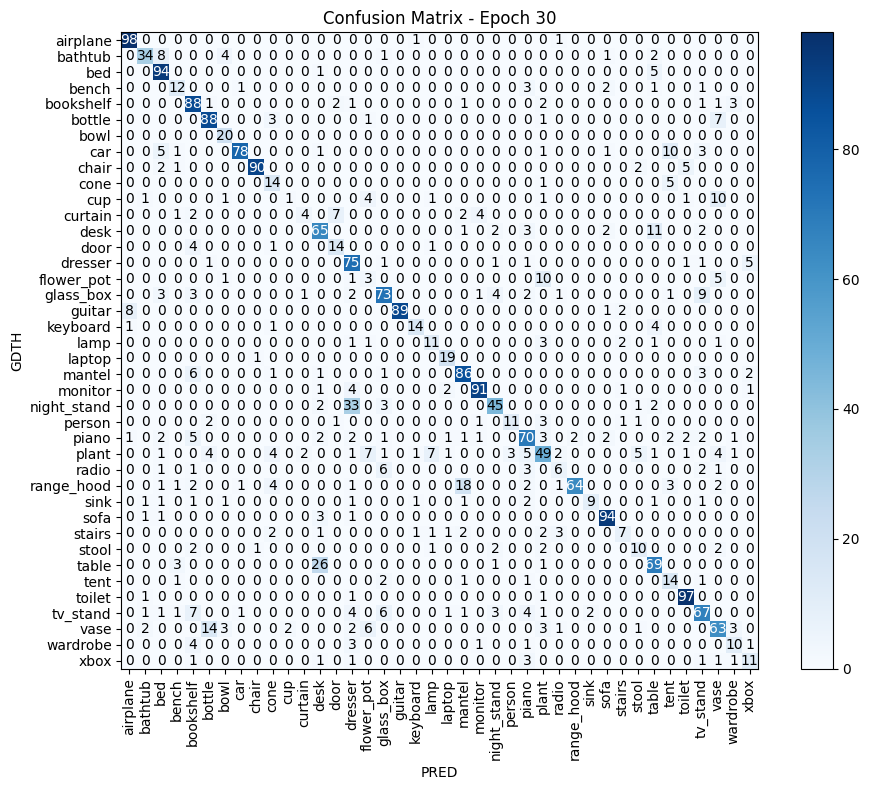

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional: for better visualization

print()

num_classes = max(max(test_preds), max(test_gdths)) + 1
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for pred_label, gdth_label in zip(test_preds, test_gdths):
    conf_matrix[gdth_label][pred_label] += 1

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - Epoch {30}')
plt.colorbar()
plt.ylabel('GDTH')
plt.xlabel('PRED')

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(
            j, i, conf_matrix[i, j], ha='center', va='center', 
            color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black'
        )

# Optional: Add class names if you have them
class_names = testt_dataset.class_names # Replace with your actual class names
plt.xticks(np.arange(num_classes), class_names, rotation=90)
plt.yticks(np.arange(num_classes), class_names)

plt.tight_layout()
plt.show()